## Core Learning Algorithms
- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

### Linear Regression
- Great for predicting _continuous_ numerical values
- Your data _must_ be _linear_ in shape/nature for it to be modeled accurately by linear regression, but the reality is real-word data is rarely structured this way.

In [1]:
import os
import sys
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
!pip list | grep -E 'tensorflow|keras'

keras                        3.9.2
tensorflow                   2.16.2
tensorflow-io-gcs-filesystem 0.37.1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

# import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

from tensorflow.keras import layers

print(tf.__version__)
# print(tf.keras.backend.backend())

/var/folders/fy/sdkjccl94_n8cnq_k1rbmzp40000gn/T/ipykernel_13877/3301962057.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2025-05-18 20:00:03.652416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


In [4]:
dftrain = pd.read_csv('../data/titanic-survivor-training-data.csv')
dfevaluate = pd.read_csv('../data/titanic-survivor-evaluation-data.csv')
print(dftrain.head())
# pop the relevant target column off for both sets.
y_train = dftrain.pop('survived')
y_eval = dfevaluate.pop('survived')

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


(627, 9)
Axes(0.125,0.11;0.775x0.77)


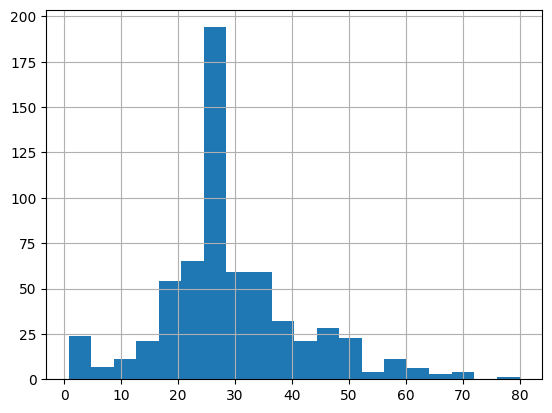

In [5]:

print(dftrain.shape)

print(dftrain.age.hist(bins=20))

In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


<Axes: ylabel='class'>

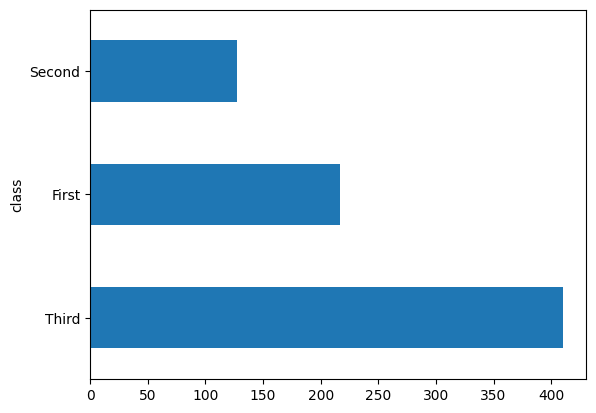

In [7]:
dftrain.sex.value_counts().plot(kind='barh')
# either way of accessing object (dataframe) keys allowed
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survived')

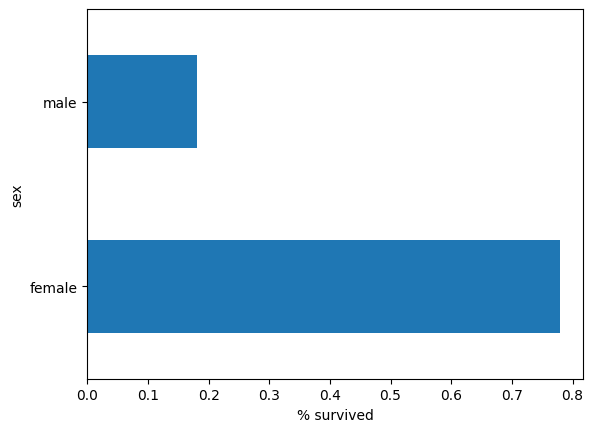

In [8]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

## Feature Columns
- Categorical data, like the `sex` column in our dataset, need to be converted from non-numerical to numerical data before the algorithm can train on them. (machines for the purposes of this argument can't understand what `Male` means and what `Female` mean )
- We can do this by encoding each category with an integer (ex. male = 1, female = 2)

In [9]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [10]:
inputs = {
    col: tf.keras.Input(shape=(1,), name=col, dtype=tf.string if dftrain[col].dtype == object else tf.float32)
    for col in CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
}

def get_lookup_layer(feature_name):
    vocab = np.unique(dftrain[feature_name].values)
    if dftrain[feature_name].dtype == object:
        return tf.keras.layers.StringLookup(vocabulary=vocab), len(vocab) + 1
    else:
        return tf.keras.layers.IntegerLookup(vocabulary=vocab), len(vocab) + 1
    
encoded_features = []

for feature_name in CATEGORICAL_COLUMNS:
    lookup, num_tokens = get_lookup_layer(feature_name=feature_name)
    encoded_indices = lookup(inputs[feature_name])
    one_hot_layer = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode='one_hot' )(encoded_indices)
    encoded_features.append(one_hot_layer)

for feature_name in NUMERIC_COLUMNS:
    # Create input layer
    inputs[feature_name] = tf.keras.Input(shape=(1,), name=feature_name, dtype=tf.float32)

    # Create and adapt normalization layer
    normalizer = tf.keras.layers.Normalization(axis=None)  # axis=None → normalize across entire column
    normalizer.adapt(np.array(dftrain[feature_name]))  # Use only training data here!

    # Apply normalization
    normalized_feature = normalizer(inputs[feature_name])

    encoded_features.append(normalized_feature)

print(len(encoded_features))
print(encoded_features)

9
[<KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>, <KerasTensor shape=(None, 8), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>, <KerasTensor shape=(None, 7), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_7>, <KerasTensor shape=(None, 9), dtype=float32, sparse=False, ragged=False, name=keras_tensor_9>, <KerasTensor shape=(None, 5), dtype=float32, sparse=False, ragged=False, name=keras_tensor_11>, <KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_13>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_14>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_15>]


## Training Process
- To account for situations where very large volumes of data are being trained on, TensorFlow allows us to _stream_ model data in __batches.__
- We'll use a batch size in this tutorial of 32 as it's going to be far more performant than 1 by 1, and less prone to error or other problems if the entire dataset were dumped in the model at once.
- An __epoch__ is one stream of the entire dataset. The number of _epochs_ defined is the amount of times the model will see the _**entire**_ dataset. Multiple epochs are used in hopes that after seeing the same data multiple times the model will better determine how to estimate / predict it. 
- Since we need to feed our data in batches, and then do so multiple times, we need to create an __input function__ _(not to be confused with activation function)._ The _input function_ will define how our dataset is partitioned or converted into _batches_ at each _epoch_